In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.fftpack import fft,ifft
from numpy import conj,argmax

In [2]:
# Set the log file path
logFileName = '150PT357'
logFileType = '.bbl'
logFilePath = logFileName+logFileType

# Set the blackbox_decode path
decodePath = 'blackbox_decode.exe'

In [3]:
# Create decode command
decodeCommand = decodePath + ' ' + logFilePath

# Decode
os.system(decodeCommand)

# blackbox_decode will create a .event file, we don't need that
junkFile = logFileName+'.01.event'
os.remove(junkFile)

In [4]:
dataFile = logFileName+'.01.csv'

df=pd.read_csv(dataFile) # read data file into a pandas dataframe
loopIteration   = df[ 'loopIteration'].values.T
time            = df[ ' time (us)'].values.T
time=time-time[0]
samplingRate = 1000000/np.median(np.diff(time)) #1000000 because the data is in us
print(samplingRate)

3215.434083601286


In [5]:
df.columns
setpointData    = df[[ ' setpoint[0]',  ' setpoint[1]', ' setpoint[2]']].values.T
gyroADCData     = df[[ ' gyroADC[0]',   ' gyroADC[1]',  ' gyroADC[2]']].values.T
gyroScaleData   = df[[ ' debug[0]',     ' debug[1]',    ' debug[2]']].values.T
thrData         = df[[ ' rcCommand[3]']].values.T[0]

In [6]:
def calc_delay(a,b):
    a_fft   = fft(np.hamming(len(a)) *a)   #a must be later than b
    b_fft   = fft(np.hamming(len(b)) *b)   #hamming for now, maybe hanning is better?
    c       = ifft(a_fft*conj(b_fft))
    time_shift  = argmax(abs(c))
    return time_shift

def inter(x):
    tmp_a = np.arange(0,len(x),1)
    tmp_b = interpolate.interp1d(tmp_a,x)
    y = tmp_b(np.arange(0,len(x)-10,0.1))
    return y

In [7]:
inputSignal = gyroScaleData[0]
outputSignal = gyroADCData[0]
overall_delay = calc_delay(outputSignal,inputSignal)
print(overall_delay)

thr = thrData #range from 1000~2000
bufferSize = 256
skip_rate = 0.25
thrDelay = np.zeros(100, dtype=np.float64)
thrCount = np.zeros(100, dtype=np.int32)

for i in range(0, len(inputSignal)-bufferSize, int(skip_rate*bufferSize)):
    idx = i
    avgThr = int(np.sum(thr[idx:idx+bufferSize])/bufferSize/10) - 100
    if avgThr < 0:
        avgThr = 0
    if avgThr > 99:
        avgThr = 99
    intered_input = inter(inputSignal[idx:idx+bufferSize])
    intered_output = inter(outputSignal[idx:idx+bufferSize])
    # Up sampling to increase precision
    tmpDelay = calc_delay(intered_output,intered_input)
    if tmpDelay > 20*overall_delay:
        continue

    delay = tmpDelay/(int(samplingRate/100)) #not 1000 because of the 10 times up sampling
    thrDelay[avgThr] = thrDelay[avgThr]+delay
    thrCount[avgThr] += 1
    
for i in range(100):
    if thrCount[i] != 0:
        thrDelay[i]=thrDelay[i]/thrCount[i]

16


<Figure size 480x320 with 0 Axes>

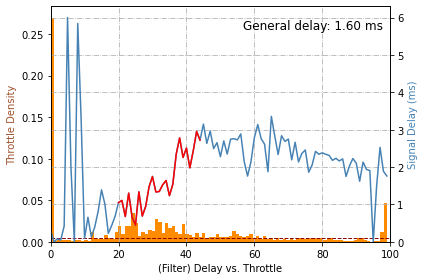

In [8]:
x = (thrData/10)-100

num_bins = 100 # 0-100
general_delay = np.sum(thrDelay[20:45]) / 25 
# only take data where throttle lies in range 20-40%, which is the most often used range

plt.figure(figsize=(6, 4), dpi= 80)
fig, ax1 = plt.subplots()
plt.xlim(0,100)
plt.grid(True,linestyle='-.',axis = 'x')
n, bins, patches = ax1.hist(x, num_bins, density=True, color="darkorange")
ax1.set_xlabel('(Filter) Delay vs. Throttle')
ax1.set_ylabel('Throttle Density', color="sienna")
plt.axhline(0.005 , color='darkred', linewidth=1, linestyle='--')

ax2 = ax1.twinx()
ax2.set_ylabel('Signal Delay (ms)', color='steelblue')
ax2.set_ylim(0,max(thrDelay)*1.05)
# we already handled the x-label with ax1
ax2.plot(thrDelay, color='steelblue')
ax2.plot(np.arange(20,45,1),thrDelay[20:45],color='red')
ax2.tick_params(axis='y')
plt.text(98, max(thrDelay)*0.95, "General delay: %.2f ms"  %general_delay, size= 'large', ha='right')
plt.grid(True,linestyle='-.')

fig.tight_layout()
plt.show()